<a href="https://colab.research.google.com/github/hongqin/alphafold-local-sandbox/blob/main/AlphaFold2PredictStructure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Protein structure prediction with AlphaFold2 and MMseqs2

Easy to use version of AlphaFold 2 (Jumper et al. 2021, Nature) using an API hosted at the Södinglab based on the MMseqs2 server (Mirdita et al. 2019, Bioinformatics) for the multiple sequence alignment creation. 

**Quickstart**
1. Change the runtime type to GPU at "Runtime" -> "Change runtime type" (improves speed)
2. Paste your protein sequence in the input field below
3. Press "Runtime" -> "Run all"
4. The pipeline has 8 steps. The currently running steps is indicated by a circle with a stop sign next to it. 

**Result**

We produce two result files (1) a PDB formated structure and (2) a plot of the model quality. At the end of the computation a download modal box will pop with a `result.tar.gz` file.

**Troubleshooting**
* Try to restart the session "Runntime" -> "Factory reset runtime"
* Check your input sequence 

**Limitations**
* MSAs: MMseqs2 might not find as many hits compared to HHblits/HMMer searched against BFD and Mgnify.
* Templates: Currently we do not use template information. But this is work in progress. 
* Computing resources: MMseqs2 can probably handle >20k requests per day since we run it only on 16 cores.

For best results, we recommend using the full pipeline: https://github.com/deepmind/alphafold

Most of the python code was written by Sergey Ovchinnikov (@sokrypton). The API is hosted at the Södinglab (@SoedingL) and maintained by Milot Mirdita (@milot_mirdita). Martin Steinegger (@thesteinegger) integrated everything.



In [ ]:
#@title Input protein sequence here before you "Run all"

query_sequence = 'MAKTIKITQTRSAIGRLPKHKATLLGLGLRRIGHTVEREDTPAIRGMINAVSFMVKVEE' #@param {type:"string"}
# remove whitespaces
query_sequence="".join(query_sequence.split())
jobname = 'RL30_ECOLI' #@param {type:"string"}
# remove whitespaces
jobname="".join(jobname.split())

with open(f"{jobname}.fasta", "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

# number of models to use
#@markdown ---
#@markdown ### Advanced settings
num_models = 5 #@param [1,2,3,4,5] {type:"raw"}
use_amber = True #@param {type:"boolean"}
use_msa = True #@param {type:"boolean"}
#@markdown ---

In [ ]:
#@title Install dependencies
%%bash -s "$use_amber"
if [ ! -f AF2_READY ]; then
  # install dependencies
  apt-get -qq -y update 2>&1 1>/dev/null
  apt-get -qq -y install jq curl zlib1g gawk 2>&1 1>/dev/null
  pip -q install biopython 2>&1 1>/dev/null
  pip -q install dm-haiku 2>&1 1>/dev/null
  pip -q install ml-collections 2>&1 1>/dev/null
  pip -q install py3Dmol 2>&1 1>/dev/null
  touch AF2_READY
fi
# download model
if [ ! -d "alphafold/" ]; then
  git clone https://github.com/deepmind/alphafold.git --quiet
  mv alphafold alphafold_
  mv alphafold_/alphafold .
fi
# download model params (~1 min)
if [ ! -d "params/" ]; then
  wget -qnc https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar
  mkdir params
  tar -xf alphafold_params_2021-07-14.tar -C params/
  rm alphafold_params_2021-07-14.tar
fi
# install openmm for refinement
if [ $1 == "True" ] && [ ! -f "alphafold/common/stereo_chemical_props.txt" ]; then
  wget -qnc https://git.scicore.unibas.ch/schwede/openstructure/-/raw/7102c63615b64735c4941278d92b554ec94415f8/modules/mol/alg/src/stereo_chemical_props.txt
  mv stereo_chemical_props.txt alphafold/common/
  wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
  bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
  conda install -y -q -c conda-forge openmm=7.5.1 python=3.7 pdbfixer 2>&1 1>/dev/null
  (cd /usr/local/lib/python3.7/site-packages; patch -s -p0 < /content/alphafold_/docker/openmm.patch)
fi

In [ ]:
#@title Build MSA
%%bash -s "$use_msa" "$jobname"
if [ $1 == "True" ]; then
  if [ -f $2.result.tar.gz ]; then
    echo "looks done"
    tar xzf $2.result.tar.gz
    tr -d '\000' < uniref.a3m > $2.a3m
  else
    # build msa using the MMseqs2 search server
    echo "submitting job"
    ID=$(curl -s -F q=@$2.fasta -F mode=all https://a3m.mmseqs.com/ticket/msa | jq -r '.id')
    STATUS=$(curl -s https://a3m.mmseqs.com/ticket/${ID} | jq -r '.status')
    while [ "${STATUS}" == "RUNNING" ]; do
        STATUS=$(curl -s https://a3m.mmseqs.com/ticket/${ID} | jq -r '.status')
        sleep 1
    done
    if [ "${STATUS}" == "COMPLETE" ]; then
        curl -s https://a3m.mmseqs.com/result/download/${ID}  > $2.result.tar.gz
        tar xzf $2.result.tar.gz
        tr -d '\000' < uniref.a3m > $2.a3m
    else
        echo "MMseqs2 server did not return a valid result."
        exit 1
    fi
  fi
  echo "Found $(grep -c ">" $2.a3m) sequences (after redundacy filtering)"
else
  cp $2.fasta $2.a3m
fi

submitting job
Found 3351 sequences (after redundacy filtering)


In [ ]:
#@title Setup model
# the following code is written by Sergey Ovchinnikov
# setup the model
if "model" not in dir():
  import warnings
  warnings.filterwarnings('ignore')
  import os
  import sys
  os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
  import tensorflow as tf
  import numpy as np
  import pickle
  import py3Dmol
  import matplotlib.pyplot as plt
  from alphafold.common import protein
  from alphafold.data import pipeline
  from alphafold.data import templates
  from alphafold.model import data
  from alphafold.model import config
  from alphafold.model import model

  import ipywidgets
  from ipywidgets import interact, fixed

  tf.get_logger().setLevel('ERROR')

if use_amber and "relax" not in dir():
  sys.path.insert(0, '/usr/local/lib/python3.7/site-packages/')
  from alphafold.relax import relax

if "model_params" not in dir(): model_params = {}
for model_name in ["model_1","model_2","model_3","model_4","model_5"][:num_models]:
  if model_name not in model_params:
    model_config = config.model_config(model_name)
    model_config.data.eval.num_ensemble = 1
    model_params[model_name] = data.get_model_haiku_params(model_name=model_name, data_dir=".")
    if model_name == "model_1":
      model_runner_1 = model.RunModel(model_config, model_params[model_name])
    if model_name == "model_3":
      model_runner_3 = model.RunModel(model_config, model_params[model_name])

def mk_mock_template(query_sequence):
  # since alphafold's model requires a template input
  # we create a blank example w/ zero input, confidence -1
  ln = len(query_sequence)
  output_templates_sequence = "-"*ln
  output_confidence_scores = np.full(ln,-1)
  templates_all_atom_positions = np.zeros((ln, templates.residue_constants.atom_type_num, 3))
  templates_all_atom_masks = np.zeros((ln, templates.residue_constants.atom_type_num))
  templates_aatype = templates.residue_constants.sequence_to_onehot(output_templates_sequence,
                                                                    templates.residue_constants.HHBLITS_AA_TO_ID)
  template_features = {'template_all_atom_positions': templates_all_atom_positions[None],
                       'template_all_atom_masks': templates_all_atom_masks[None],
                       'template_sequence': [f'none'.encode()],
                       'template_aatype': np.array(templates_aatype)[None],
                       'template_confidence_scores': output_confidence_scores[None],
                       'template_domain_names': [f'none'.encode()],
                       'template_release_date': [f'none'.encode()]}
  return template_features

def set_bfactor(pdb_filename, bfac):
  I = open(pdb_filename,"r").readlines()
  O = open(pdb_filename,"w")
  for line in I:
    if line[0:6] == "ATOM  ":
      seq_id = int(line[23:26].strip()) - 1
      O.write("{prefix}{bfac:6.2f}{suffix}".format(prefix=line[:60], bfac=bfac[seq_id], suffix=line[66:]))
  O.close()

def predict_structure(prefix, feature_dict, do_relax=True, random_seed=0):  
  """Predicts structure using AlphaFold for the given sequence."""

  # Run the models.
  plddts = []
  unrelaxed_pdb_lines = []
  relaxed_pdb_lines = []

  for model_name, params in model_params.items():
    print(f"running {model_name}")
    # swap params to avoid recompiling
    # note: models 1,2 have diff number of params compared to models 3,4,5
    if any(str(m) in model_name for m in [1,2]): model_runner = model_runner_1
    if any(str(m) in model_name for m in [3,4,5]): model_runner = model_runner_3
    model_runner.params = params
    
    processed_feature_dict = model_runner.process_features(feature_dict, random_seed=random_seed)
    prediction_result = model_runner.predict(processed_feature_dict)
    unrelaxed_protein = protein.from_prediction(processed_feature_dict,prediction_result)
    unrelaxed_pdb_lines.append(protein.to_pdb(unrelaxed_protein))
    plddts.append(prediction_result['plddt'])

    if do_relax:
      # Relax the prediction.
      amber_relaxer = relax.AmberRelaxation(max_iterations=0,tolerance=2.39,
                                            stiffness=10.0,exclude_residues=[],
                                            max_outer_iterations=20)      
      relaxed_pdb_str, _, _ = amber_relaxer.process(prot=unrelaxed_protein)
      relaxed_pdb_lines.append(relaxed_pdb_str)

  # rerank models based on predicted lddt
  lddt_rank = np.mean(plddts,-1).argsort()[::-1]
  plddts_ranked = {}
  for n,r in enumerate(lddt_rank):
    print(f"model_{n+1} {np.mean(plddts[r])}")

    unrelaxed_pdb_path = f'{prefix}_unrelaxed_model_{n+1}.pdb'    
    with open(unrelaxed_pdb_path, 'w') as f: f.write(unrelaxed_pdb_lines[r])
    set_bfactor(unrelaxed_pdb_path,plddts[r]/100)

    if do_relax:
      relaxed_pdb_path = f'{prefix}_relaxed_model_{n+1}.pdb'
      with open(relaxed_pdb_path, 'w') as f: f.write(relaxed_pdb_lines[r])
      set_bfactor(relaxed_pdb_path,plddts[r]/100)

    plddts_ranked[f"model_{n+1}"] = plddts[r]

  return plddts_ranked

In [ ]:
#@title Predict structure
a3m_lines = "".join(open(f"{jobname}.a3m","r").readlines())
msa, deletion_matrix = pipeline.parsers.parse_a3m(a3m_lines)
query_sequence = msa[0]
feature_dict = {
    **pipeline.make_sequence_features(sequence=query_sequence,
                                      description="none",
                                      num_res=len(query_sequence)),
    **pipeline.make_msa_features(msas=[msa],deletion_matrices=[deletion_matrix]),
    **mk_mock_template(query_sequence)
}
plddts = predict_structure(jobname, feature_dict, do_relax=use_amber)

model_1 92.44848268102942
model_2 90.9884386024141
model_3 93.22937379857797
model_4 94.80244068565474
model_5 91.9913274542571


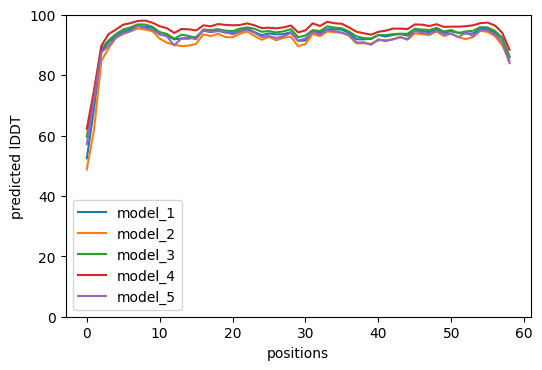

In [ ]:
#@title Plot lDDT per residue
# confidence per position
plt.figure(dpi=100)
for model_name,value in plddts.items():
  plt.plot(value,label=model_name)
plt.legend()
plt.ylim(0,100)
plt.ylabel("predicted lDDT")
plt.xlabel("positions")
plt.savefig(jobname+"_lDDT.png")
plt.show()

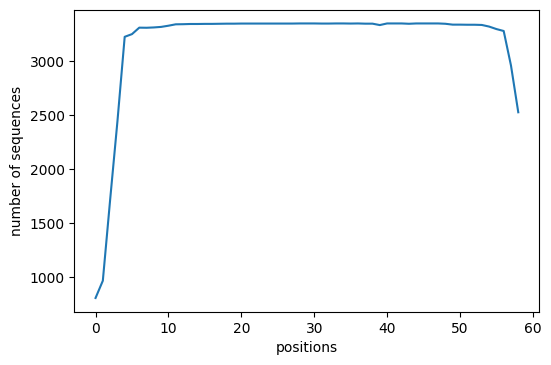

In [ ]:
#@title Plot Number of Sequences per Position
# confidence per position
plt.figure(dpi=100)
plt.plot((feature_dict["msa"] != 21).sum(0))
plt.xlabel("positions")
plt.ylabel("number of sequences")
plt.show()

In [ ]:
#@title Show 3D structure
def show_pdb(model_name,
             show_sidechains=False,
             show_mainchain=False,
             color="None"):

  def mainchain(p, color="white", model=0):
    BB = ['C','O','N','CA']
    p.addStyle({"model":model,'atom':BB},
                       {'stick':{'colorscheme':f"{color}Carbon",'radius':0.4}})

  def sidechain(p, model=0):
    HP = ["ALA","GLY","VAL","ILE","LEU","PHE","MET","PRO","TRP","CYS","TYR"]
    BB = ['C','O','N']
    p.addStyle({"model":model,'and':[{'resn':HP},{'atom':BB,'invert':True}]},
              {'stick':{'colorscheme':"yellowCarbon",'radius':0.4}})
    p.addStyle({"model":model,'and':[{'resn':"GLY"},{'atom':'CA'}]},
              {'sphere':{'colorscheme':"yellowCarbon",'radius':0.4}})
    p.addStyle({"model":model,'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
              {'stick':{'colorscheme':"yellowCarbon",'radius':0.4}})  
    p.addStyle({"model":model,'and':[{'resn':HP,'invert':True},{'atom':BB,'invert':True}]},
              {'stick':{'colorscheme':"whiteCarbon",'radius':0.4}})

  if use_amber:
    pdb_filename = f"{jobname}_relaxed_{model_name}.pdb"
  else:
    pdb_filename = f"{jobname}_unrelaxed_{model_name}.pdb"

  p = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  p.addModel(open(pdb_filename,'r').read(),'pdb')
  if color == "lDDT":
    p.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':1}}})
  elif color == "rainbow":
    p.setStyle({'cartoon': {'color':'spectrum'}})
  else:
    p.setStyle({'cartoon':{}})

  if show_sidechains: sidechain(p)
  if show_mainchain: mainchain(p)
  p.zoomTo()
  return p.show()

interact(show_pdb,
         model_name=ipywidgets.Dropdown(options=model_params.keys(), value='model_1'),
         show_sidechains=ipywidgets.Checkbox(value=False),
         show_mainchain=ipywidgets.Checkbox(value=False),
         color=ipywidgets.Dropdown(options=['None', 'rainbow', 'lDDT'], value='lDDT'))

interactive(children=(Dropdown(description='model_name', options=('model_1', 'model_2', 'model_3', 'model_4', …

<function __main__.show_pdb>

In [ ]:
#@title Download result
!tar cfz $jobname".result.tar.gz" $jobname"_"*"relaxed_model_"*".pdb" $jobname"_lDDT.png"
from google.colab import files
files.download(f"{jobname}.result.tar.gz")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>